## Current Status:
Still in progress. Also trying some simpler problems similar to this side by side to get better insight. Will probably try WGAN Loss and A RNN based policy model as suggested in SPIRAL paper

## Goal:
To train a DQN to draw an MNIST digit on a blank canvas. <br>
As someone who has worked on GANs a lot, it struct to me that GANs generate images in one-shot, as opposed to humans, who draw in a sequential manner. Hence I try to use RL in order to experiment if DQN can generate/draw an MNIST digit by taking a sequence of steps on a blank canvas.


## References:
- https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
- https://github.com/pytorch/examples/blob/master/mnist/main.py
- SPIRAL Paper

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import spaces

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import os
import random
import math
from collections import namedtuple
from itertools import count

In [0]:
# GAN Parameters

GAN_BATCH_SIZE = 1024
GAN_LR = 0.00001

# DQN Parameters

DQN_BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.001
TARGET_UPDATE = 10
DQN_LR = 0.001

# General Parameters

nb_epochs = 10
DIGIT = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = list()
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [68]:
os.makedirs("data/", exist_ok=True)
dataset = datasets.MNIST(root="data/MNIST/", train=True, download=True, transform=transforms.ToTensor())

idx = (dataset.train_labels == DIGIT)
dataset.targets = dataset.train_labels[idx]
dataset.data = dataset.train_data[idx]
dataloader = torch.utils.data.DataLoader(dataset, batch_size=GAN_BATCH_SIZE, shuffle=True)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.dropout1(F.relu(self.conv1(x)))
        x = self.dropout1(F.max_pool2d(self.conv2(x), 2))
        # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.dropout3(F.relu(self.fc1(x)))
        # x = self.dropout2(x)
        validity = torch.sigmoid(self.fc2(x))
        return validity

In [0]:
def get_dis_result(dis_in, dis_model):
    return dis_model(dis_in)

In [0]:
class CanvasEnv(gym.Env):
    def __init__(self):
        super(CanvasEnv, self).__init__()
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Box(low=0, high=1, shape=(28, 28), dtype=int)
        
        self.canvas = np.zeros((28, 28), dtype=int)
        self.position_on_canvas = np.zeros((28, 28), dtype=int)
        self.pen_down = False
        
        self.action_map = {
            0: "left",
            1: "up",
            2: "right",
            3: "bottom",
            4: "switch",
            5: "stop"
        }
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def step(self, action, reward_model):
        done = False
        beyond_limit = False
        
        self.position_on_canvas[self.x, self.y] = 0
        
        if self.action_map[action] == "left":
            if self.y == 0:
                beyond_limit = True
            self.y = max(0, self.y-1)
        elif self.action_map[action] == "right":
            if self.y == 27:
                beyond_limit = True
            self.y = min(27, self.y+1)
        elif self.action_map[action] == "up":
            if self.x == 0:
                beyond_limit = True
            self.x = max(0, self.x-1)
        elif self.action_map[action] == "down":
            if self.x == 27:
                beyond_limit = True
            self.x = min(27, self.x+1)
        elif self.action_map[action] == "switch":
            self.pen_down = not self.pen_down
        elif self.action_map[action] == "stop":
            done = True
            
        self.position_on_canvas[self.x, self.y] = 1
        if self.pen_down:
            self.canvas[self.x, self.y] = 1
        
        if done:
          reward_input = torch.from_numpy(self.canvas).view(1, 1, 28, 28).float().to(self.device)
          reward_output = get_dis_result(reward_input, reward_model)   
          reward = reward_output.cpu().detach().numpy()
        else:
          reward = torch.FloatTensor([[0]])

        # reward_input = torch.from_numpy(self.canvas).view(1, 1, 28, 28).float().to(self.device)
        # reward_output = get_dis_result(reward_input, reward_model)   
        # reward = reward_output.cpu().detach().numpy()
        # print(reward.shape)
        
        return self.as_tensor(np.concatenate([self.position_on_canvas, self.canvas])), reward, done
    
    def reset(self):
        self.canvas *= 0
        self.position_on_canvas *= 0
        self.x, self.y = random.randint(0, 27), random.randint(0, 27)
        self.pen_down = False
        self.position_on_canvas[self.x, self.y] = 1
        return self.as_tensor(np.concatenate([self.position_on_canvas, self.canvas]))
    
    def render(self):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(self.position_on_canvas)
        axarr[1].imshow(self.canvas)
        plt.show()
        
    def as_tensor(self, array):
        array = np.reshape(array, [1, 2, 28, 28])
        return torch.from_numpy(array).float().to(self.device)

In [0]:
# class DQN(nn.Module):
    def __init__(self, nb_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(128*10*10, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, nb_actions)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [0]:
class Generator():
    def __init__(self, env):
        self.env = env
        self.nb_actions = env.action_space.n
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.policy_net = DQN(self.nb_actions).to(self.device)
        self.target_net = DQN(self.nb_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.DQN_optimizer = optim.Adam(self.policy_net.parameters(), DQN_LR)
        
        self.memory = ReplayMemory(10000)
        self.num_episode = 10
        self.eps = EPS_START
        self.eps_threshold = EPS_END
        
        self.episode_durations = list()
        
    def select_action(self, state, greedy=False):
        sample = random.random()
        if sample > self.eps or greedy:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1]
        else:
            return torch.tensor([random.randrange(self.nb_actions)], device=device, dtype=torch.long)
        
    def get_samples(self, number, reward_model, greedy=False):
        samples = list()
        for _ in range(number):
            done = False
            state = self.env.reset()
            while not done:
                action = int(self.select_action(state, greedy))
                state, reward, done = self.env.step(action, reward_model)
            samples.append(state.cpu().detach().numpy())
        return np.squeeze(np.array(samples))
            

#     def plot_durations(self):
#         plt.figure(2)
#         plt.clf()
#         durations_t = torch.tensor(episode_durations, dtype=torch.float)
#         plt.title('Training...')
#         plt.xlabel('Eposide')
#         plt.ylabel('Duration')
#         plt.plot(durations_t.numpy())
#         if len(durations_t) >= 100:
#             means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
#             means = torch.cat((torch.zeros(99), means))
#             plt.plot(means.numpy())
#         plt.pause(0.001)
        
    
    def optimize_model(self):
        if len(self.memory) < DQN_BATCH_SIZE:
            return
        transitions = self.memory.sample(DQN_BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                    batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch.view(-1, 1))

#         next_state_values = torch.zeros(DQN_BATCH_SIZE, device=device).double()
        next_state_values = torch.zeros(DQN_BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.DQN_optimizer.zero_grad()
        loss.backward()
#         for param in self.policy_net.parameters():
#             param.grad.data.clamp_(-1, 1)
        self.DQN_optimizer.step()
    
    def training_step(self, reward_model):
        generated_samples = []
        for i_episode in range(1, self.num_episode+1):
            print("\rRunning Episode {}/{}, Epsilon = {}".format(i_episode, self.num_episode, self.eps), end="")
            state = self.env.reset()
            
            for t in count():
                action = self.select_action(state)
                next_state, reward, done = env.step(action.item(), reward_model)
                reward = torch.tensor(reward, device=self.device)
                if done:
                    next_state = None
                    
                self.memory.push(state, action, next_state, reward)
                state = next_state
                self.optimize_model()
                
                if done:
                    self.episode_durations.append(t+1)
                    # self.plot_durations()
                    # self.env.render()
                    break
                    
            if i_episode % TARGET_UPDATE == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
            if i_episode % 10 == 0:
                self.eps = max(self.eps - EPS_DECAY, EPS_END)
                
        env.render()
#         env.close()
#         plt.ioff()
#         plt.show()

In [0]:
dis = Discriminator()
if torch.cuda.is_available():
    dis.cuda()

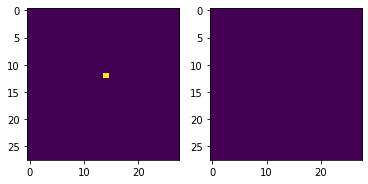

In [75]:
env = CanvasEnv()
env.reset()
env.render()

In [0]:
gen = Generator(env)

In [0]:
adversarial_loss = torch.nn.BCELoss()
if torch.cuda.is_available():
    adversarial_loss.cuda()

In [0]:
dis_optimizer = optim.Adam(dis.parameters(), lr=GAN_LR)

In [0]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

Epoch: 1/10 Batch: 1/7
Running Episode 10/10, Epsilon = 1.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


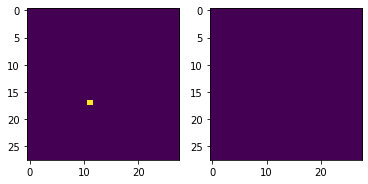

Discriminator [Total: 0.6962 Real: 0.7290 Generated: 0.6634] Generator 0.7245
Epoch: 1/10 Batch: 2/7
Running Episode 10/10, Epsilon = 0.999

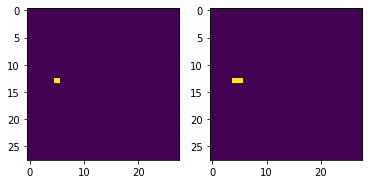

Discriminator [Total: 0.6940 Real: 0.7247 Generated: 0.6633] Generator 0.7235
Epoch: 1/10 Batch: 3/7
Running Episode 3/10, Epsilon = 0.998

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Using a target size (torch.Size([128, 1, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Running Episode 10/10, Epsilon = 0.998

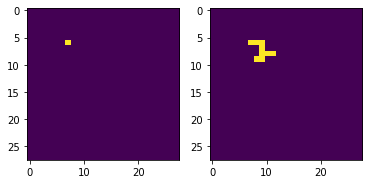

Discriminator [Total: 0.6911 Real: 0.7193 Generated: 0.6628] Generator 0.7240
Epoch: 1/10 Batch: 4/7
Running Episode 10/10, Epsilon = 0.997

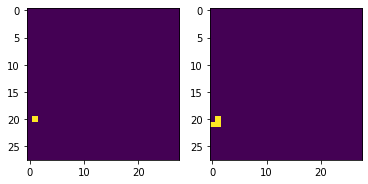

Discriminator [Total: 0.6884 Real: 0.7142 Generated: 0.6626] Generator 0.7247
Epoch: 1/10 Batch: 5/7
Running Episode 10/10, Epsilon = 0.996

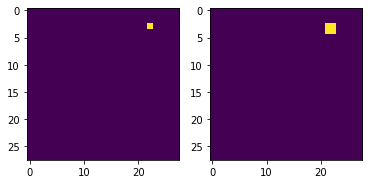

Discriminator [Total: 0.6859 Real: 0.7091 Generated: 0.6626] Generator 0.7251
Epoch: 1/10 Batch: 6/7
Running Episode 10/10, Epsilon = 0.995

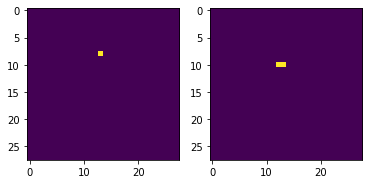

Discriminator [Total: 0.6833 Real: 0.7045 Generated: 0.6622] Generator 0.7242
Epoch: 1/10 Batch: 7/7
Running Episode 10/10, Epsilon = 0.994

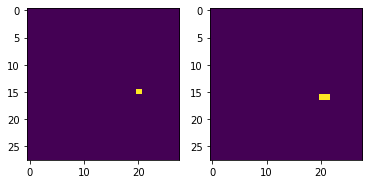

Discriminator [Total: 0.6806 Real: 0.6994 Generated: 0.6618] Generator 0.7254
Epoch: 2/10 Batch: 1/7
Running Episode 10/10, Epsilon = 0.993

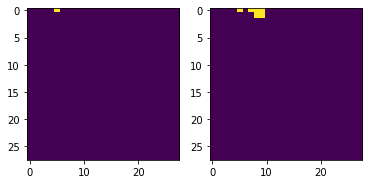

Discriminator [Total: 0.6788 Real: 0.6952 Generated: 0.6625] Generator 0.7260
Epoch: 2/10 Batch: 2/7
Running Episode 10/10, Epsilon = 0.992

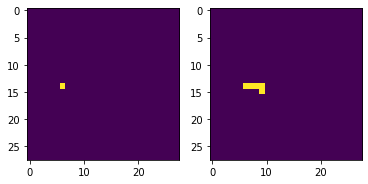

Discriminator [Total: 0.6759 Real: 0.6905 Generated: 0.6614] Generator 0.7269
Epoch: 2/10 Batch: 3/7
Running Episode 10/10, Epsilon = 0.991

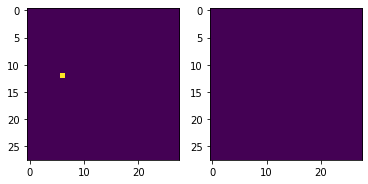

Discriminator [Total: 0.6727 Real: 0.6856 Generated: 0.6598] Generator 0.7285
Epoch: 2/10 Batch: 4/7
Running Episode 10/10, Epsilon = 0.99

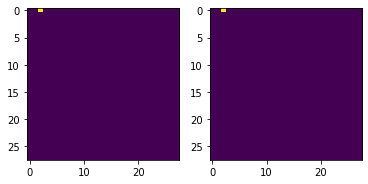

Discriminator [Total: 0.6712 Real: 0.6828 Generated: 0.6595] Generator 0.7287
Epoch: 2/10 Batch: 5/7
Running Episode 10/10, Epsilon = 0.989

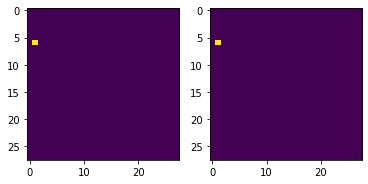

Discriminator [Total: 0.6680 Real: 0.6782 Generated: 0.6579] Generator 0.7306
Epoch: 2/10 Batch: 6/7
Running Episode 10/10, Epsilon = 0.988

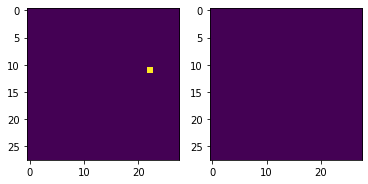

Discriminator [Total: 0.6656 Real: 0.6746 Generated: 0.6566] Generator 0.7318
Epoch: 2/10 Batch: 7/7
Running Episode 10/10, Epsilon = 0.987

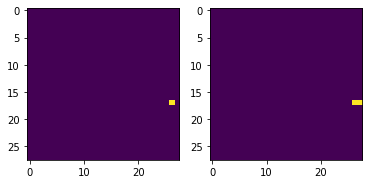

Discriminator [Total: 0.6626 Real: 0.6704 Generated: 0.6547] Generator 0.7343
Epoch: 3/10 Batch: 1/7
Running Episode 10/10, Epsilon = 0.986

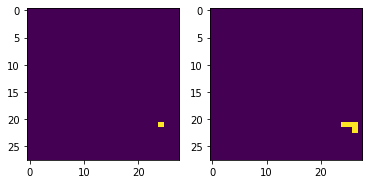

Discriminator [Total: 0.6598 Real: 0.6661 Generated: 0.6534] Generator 0.7356
Epoch: 3/10 Batch: 2/7
Running Episode 10/10, Epsilon = 0.985

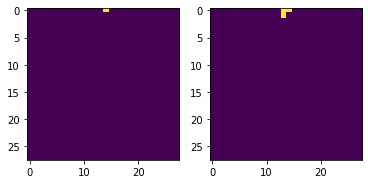

Discriminator [Total: 0.6582 Real: 0.6647 Generated: 0.6518] Generator 0.7354
Epoch: 3/10 Batch: 3/7
Running Episode 10/10, Epsilon = 0.984

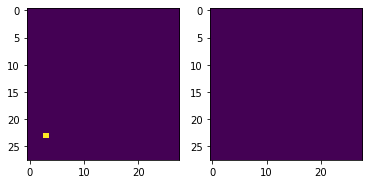

Discriminator [Total: 0.6549 Real: 0.6601 Generated: 0.6496] Generator 0.7382
Epoch: 3/10 Batch: 4/7
Running Episode 10/10, Epsilon = 0.983

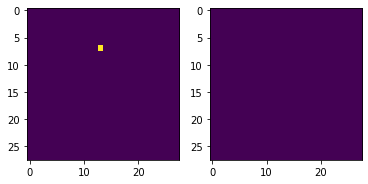

Discriminator [Total: 0.6532 Real: 0.6580 Generated: 0.6485] Generator 0.7401
Epoch: 3/10 Batch: 5/7
Running Episode 10/10, Epsilon = 0.982

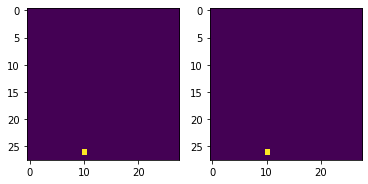

Discriminator [Total: 0.6500 Real: 0.6516 Generated: 0.6484] Generator 0.7413
Epoch: 3/10 Batch: 6/7
Running Episode 10/10, Epsilon = 0.981

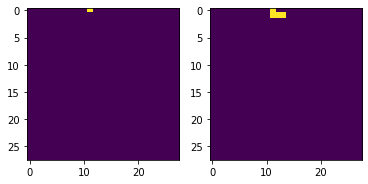

Discriminator [Total: 0.6473 Real: 0.6490 Generated: 0.6457] Generator 0.7445
Epoch: 3/10 Batch: 7/7
Running Episode 10/10, Epsilon = 0.98

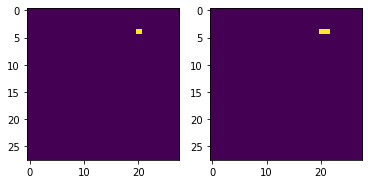

Discriminator [Total: 0.6454 Real: 0.6457 Generated: 0.6452] Generator 0.7461
Epoch: 4/10 Batch: 1/7
Running Episode 10/10, Epsilon = 0.979

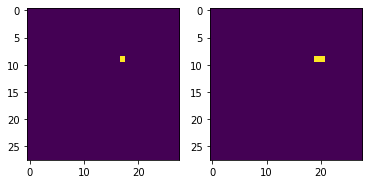

Discriminator [Total: 0.6415 Real: 0.6426 Generated: 0.6405] Generator 0.7492
Epoch: 4/10 Batch: 2/7
Running Episode 10/10, Epsilon = 0.978

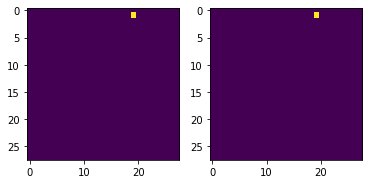

Discriminator [Total: 0.6398 Real: 0.6398 Generated: 0.6399] Generator 0.7515
Epoch: 4/10 Batch: 3/7
Running Episode 10/10, Epsilon = 0.977

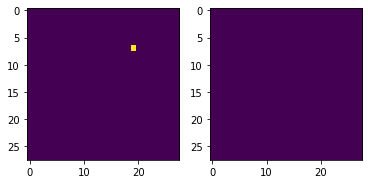

Discriminator [Total: 0.6354 Real: 0.6364 Generated: 0.6345] Generator 0.7527
Epoch: 4/10 Batch: 4/7
Running Episode 10/10, Epsilon = 0.976

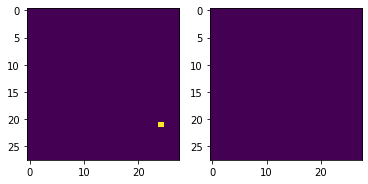

Discriminator [Total: 0.6326 Real: 0.6320 Generated: 0.6332] Generator 0.7584
Epoch: 4/10 Batch: 5/7
Running Episode 10/10, Epsilon = 0.975

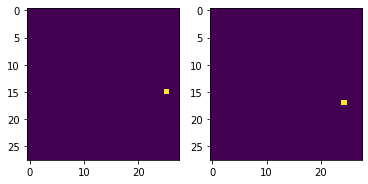

Discriminator [Total: 0.6313 Real: 0.6320 Generated: 0.6307] Generator 0.7621
Epoch: 4/10 Batch: 6/7
Running Episode 10/10, Epsilon = 0.974

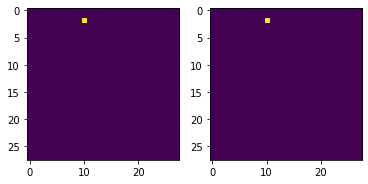

Discriminator [Total: 0.6272 Real: 0.6264 Generated: 0.6281] Generator 0.7626
Epoch: 4/10 Batch: 7/7
Running Episode 10/10, Epsilon = 0.973

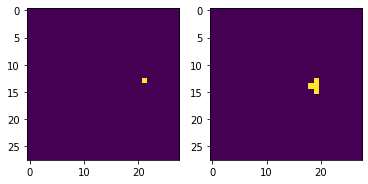

Discriminator [Total: 0.6227 Real: 0.6230 Generated: 0.6225] Generator 0.7678
Epoch: 5/10 Batch: 1/7
Running Episode 10/10, Epsilon = 0.972

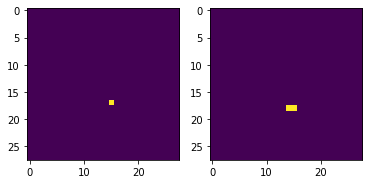

Discriminator [Total: 0.6236 Real: 0.6241 Generated: 0.6231] Generator 0.7694
Epoch: 5/10 Batch: 2/7
Running Episode 10/10, Epsilon = 0.971

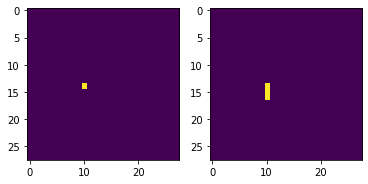

Discriminator [Total: 0.6198 Real: 0.6193 Generated: 0.6202] Generator 0.7746
Epoch: 5/10 Batch: 3/7
Running Episode 10/10, Epsilon = 0.97

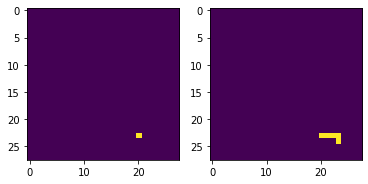

Discriminator [Total: 0.6177 Real: 0.6188 Generated: 0.6165] Generator 0.7797
Epoch: 5/10 Batch: 4/7
Running Episode 10/10, Epsilon = 0.969

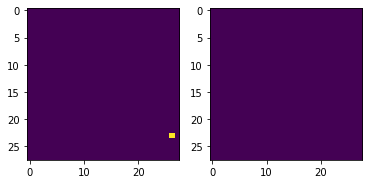

Discriminator [Total: 0.6127 Real: 0.6128 Generated: 0.6127] Generator 0.7829
Epoch: 5/10 Batch: 5/7
Running Episode 10/10, Epsilon = 0.968

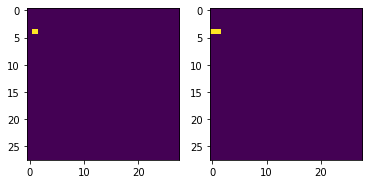

Discriminator [Total: 0.6107 Real: 0.6124 Generated: 0.6091] Generator 0.7849
Epoch: 5/10 Batch: 6/7
Running Episode 10/10, Epsilon = 0.967

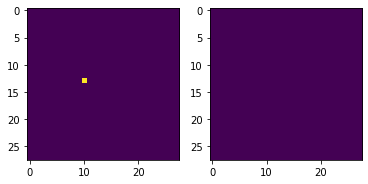

Discriminator [Total: 0.6089 Real: 0.6099 Generated: 0.6078] Generator 0.7878
Epoch: 5/10 Batch: 7/7
Running Episode 10/10, Epsilon = 0.966

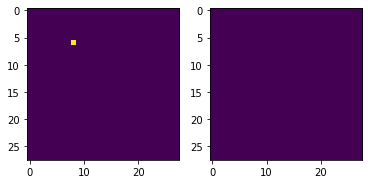

Discriminator [Total: 0.6069 Real: 0.6091 Generated: 0.6047] Generator 0.7908
Epoch: 6/10 Batch: 1/7
Running Episode 10/10, Epsilon = 0.965

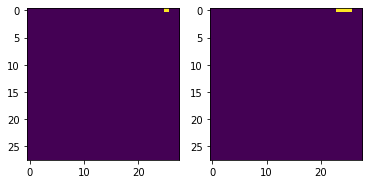

Discriminator [Total: 0.6009 Real: 0.6027 Generated: 0.5992] Generator 0.7931
Epoch: 6/10 Batch: 2/7
Running Episode 10/10, Epsilon = 0.964

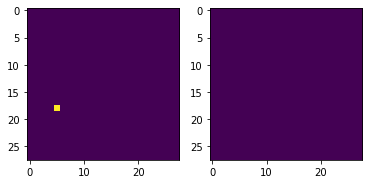

Discriminator [Total: 0.6007 Real: 0.6015 Generated: 0.5999] Generator 0.7999
Epoch: 6/10 Batch: 3/7
Running Episode 10/10, Epsilon = 0.963

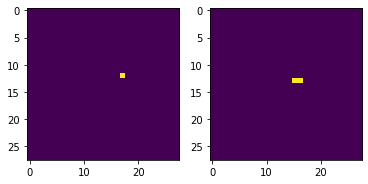

Discriminator [Total: 0.5984 Real: 0.6007 Generated: 0.5962] Generator 0.8026
Epoch: 6/10 Batch: 4/7
Running Episode 10/10, Epsilon = 0.962

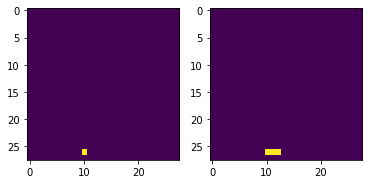

Discriminator [Total: 0.5936 Real: 0.5922 Generated: 0.5949] Generator 0.8091
Epoch: 6/10 Batch: 5/7
Running Episode 10/10, Epsilon = 0.961

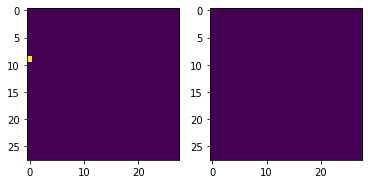

Discriminator [Total: 0.5911 Real: 0.5906 Generated: 0.5916] Generator 0.8075
Epoch: 6/10 Batch: 6/7
Running Episode 10/10, Epsilon = 0.96

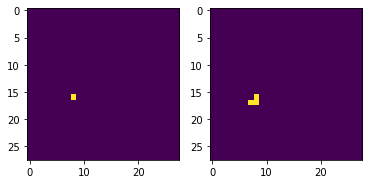

Discriminator [Total: 0.5891 Real: 0.5894 Generated: 0.5889] Generator 0.8132
Epoch: 6/10 Batch: 7/7
Running Episode 10/10, Epsilon = 0.959

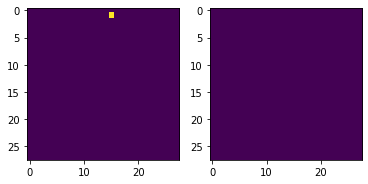

Discriminator [Total: 0.5865 Real: 0.5867 Generated: 0.5864] Generator 0.8156
Epoch: 7/10 Batch: 1/7
Running Episode 10/10, Epsilon = 0.958

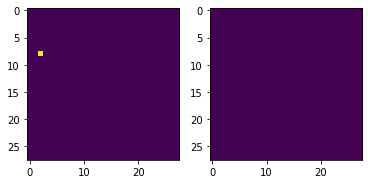

Discriminator [Total: 0.5825 Real: 0.5811 Generated: 0.5839] Generator 0.8190
Epoch: 7/10 Batch: 2/7
Running Episode 10/10, Epsilon = 0.957

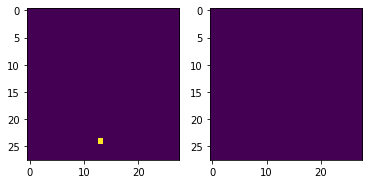

Discriminator [Total: 0.5803 Real: 0.5798 Generated: 0.5807] Generator 0.8253
Epoch: 7/10 Batch: 3/7
Running Episode 10/10, Epsilon = 0.956

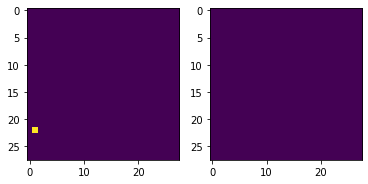

Discriminator [Total: 0.5771 Real: 0.5740 Generated: 0.5801] Generator 0.8290
Epoch: 7/10 Batch: 4/7
Running Episode 10/10, Epsilon = 0.955

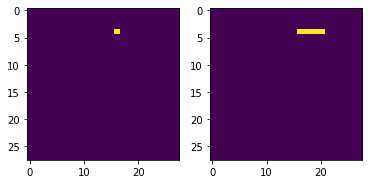

Discriminator [Total: 0.5751 Real: 0.5750 Generated: 0.5753] Generator 0.8319
Epoch: 7/10 Batch: 5/7
Running Episode 10/10, Epsilon = 0.954

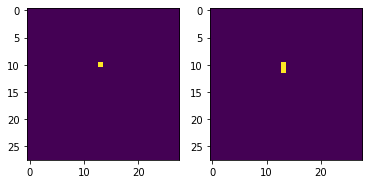

Discriminator [Total: 0.5702 Real: 0.5700 Generated: 0.5704] Generator 0.8316
Epoch: 7/10 Batch: 6/7
Running Episode 10/10, Epsilon = 0.953

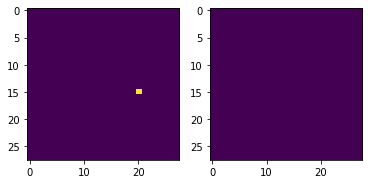

Discriminator [Total: 0.5666 Real: 0.5668 Generated: 0.5663] Generator 0.8382
Epoch: 7/10 Batch: 7/7
Running Episode 10/10, Epsilon = 0.952

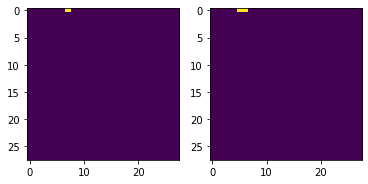

Discriminator [Total: 0.5638 Real: 0.5628 Generated: 0.5647] Generator 0.8392
Epoch: 8/10 Batch: 1/7
Running Episode 10/10, Epsilon = 0.951

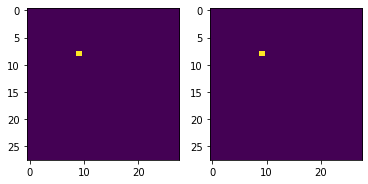

Discriminator [Total: 0.5644 Real: 0.5650 Generated: 0.5638] Generator 0.8468
Epoch: 8/10 Batch: 2/7
Running Episode 10/10, Epsilon = 0.95

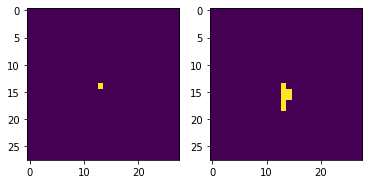

Discriminator [Total: 0.5593 Real: 0.5575 Generated: 0.5611] Generator 0.8467
Epoch: 8/10 Batch: 3/7
Running Episode 10/10, Epsilon = 0.949

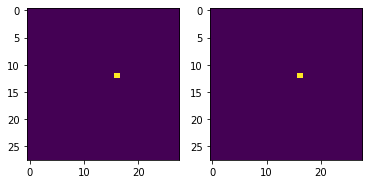

Discriminator [Total: 0.5583 Real: 0.5598 Generated: 0.5568] Generator 0.8496
Epoch: 8/10 Batch: 4/7
Running Episode 10/10, Epsilon = 0.948

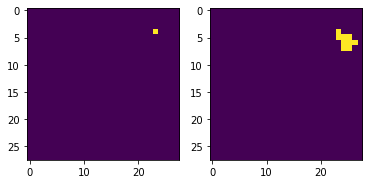

Discriminator [Total: 0.5509 Real: 0.5496 Generated: 0.5522] Generator 0.8605
Epoch: 8/10 Batch: 5/7
Running Episode 10/10, Epsilon = 0.947

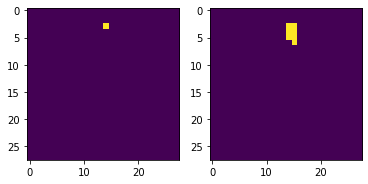

Discriminator [Total: 0.5476 Real: 0.5480 Generated: 0.5473] Generator 0.8637
Epoch: 8/10 Batch: 6/7
Running Episode 10/10, Epsilon = 0.946

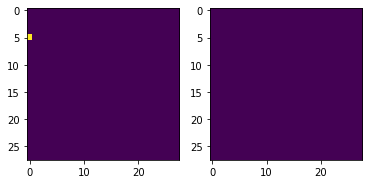

Discriminator [Total: 0.5479 Real: 0.5468 Generated: 0.5490] Generator 0.8688
Epoch: 8/10 Batch: 7/7
Running Episode 10/10, Epsilon = 0.945

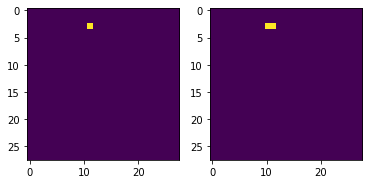

Discriminator [Total: 0.5458 Real: 0.5498 Generated: 0.5418] Generator 0.8750
Epoch: 9/10 Batch: 1/7
Running Episode 10/10, Epsilon = 0.944

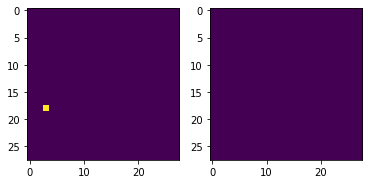

Discriminator [Total: 0.5404 Real: 0.5411 Generated: 0.5397] Generator 0.8778
Epoch: 9/10 Batch: 2/7
Running Episode 10/10, Epsilon = 0.943

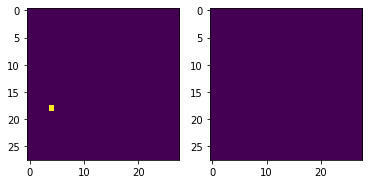

Discriminator [Total: 0.5375 Real: 0.5362 Generated: 0.5389] Generator 0.8807
Epoch: 9/10 Batch: 3/7
Running Episode 10/10, Epsilon = 0.942

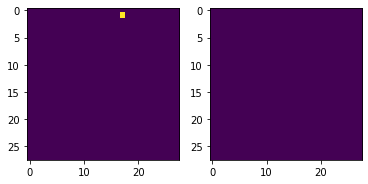

Discriminator [Total: 0.5344 Real: 0.5360 Generated: 0.5328] Generator 0.8912
Epoch: 9/10 Batch: 4/7
Running Episode 10/10, Epsilon = 0.941

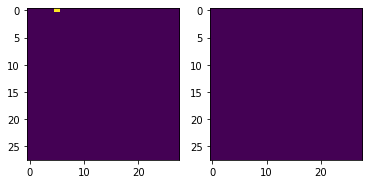

Discriminator [Total: 0.5332 Real: 0.5369 Generated: 0.5294] Generator 0.8846
Epoch: 9/10 Batch: 5/7
Running Episode 10/10, Epsilon = 0.94

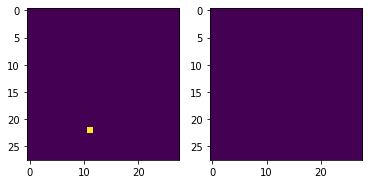

Discriminator [Total: 0.5302 Real: 0.5308 Generated: 0.5296] Generator 0.8969
Epoch: 9/10 Batch: 6/7
Running Episode 10/10, Epsilon = 0.939

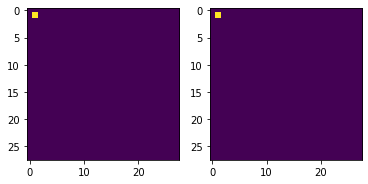

Discriminator [Total: 0.5250 Real: 0.5246 Generated: 0.5254] Generator 0.9103
Epoch: 9/10 Batch: 7/7
Running Episode 10/10, Epsilon = 0.938

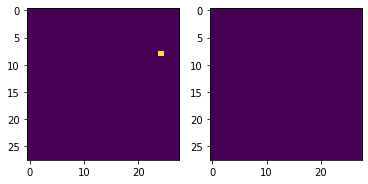

Discriminator [Total: 0.5244 Real: 0.5271 Generated: 0.5217] Generator 0.9001
Epoch: 10/10 Batch: 1/7
Running Episode 10/10, Epsilon = 0.9369999999999999

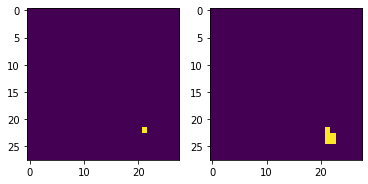

Discriminator [Total: 0.5218 Real: 0.5205 Generated: 0.5230] Generator 0.9113
Epoch: 10/10 Batch: 2/7
Running Episode 10/10, Epsilon = 0.9359999999999999

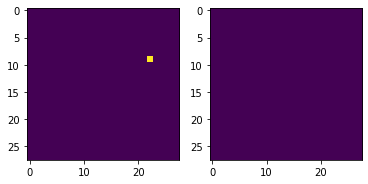

Discriminator [Total: 0.5188 Real: 0.5213 Generated: 0.5163] Generator 0.9172
Epoch: 10/10 Batch: 3/7
Running Episode 10/10, Epsilon = 0.9349999999999999

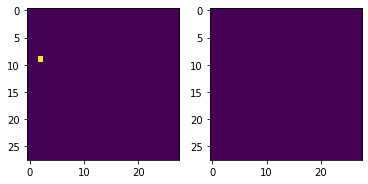

Discriminator [Total: 0.5173 Real: 0.5177 Generated: 0.5169] Generator 0.9198
Epoch: 10/10 Batch: 4/7
Running Episode 10/10, Epsilon = 0.9339999999999999

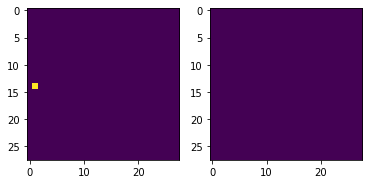

Discriminator [Total: 0.5114 Real: 0.5155 Generated: 0.5073] Generator 0.9276
Epoch: 10/10 Batch: 5/7
Running Episode 10/10, Epsilon = 0.9329999999999999

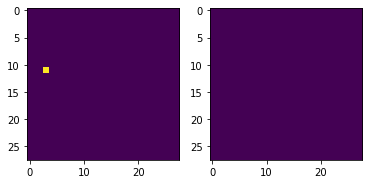

Discriminator [Total: 0.5100 Real: 0.5120 Generated: 0.5079] Generator 0.9279
Epoch: 10/10 Batch: 6/7
Running Episode 10/10, Epsilon = 0.9319999999999999

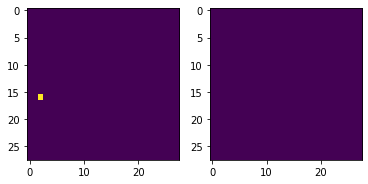

Discriminator [Total: 0.5036 Real: 0.5038 Generated: 0.5034] Generator 0.9341
Epoch: 10/10 Batch: 7/7
Running Episode 10/10, Epsilon = 0.9309999999999999

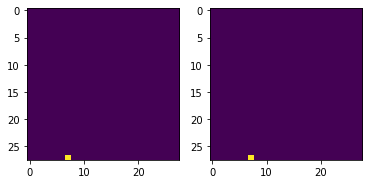

Discriminator [Total: 0.5017 Real: 0.5010 Generated: 0.5023] Generator 0.9341


In [80]:
for epoch in range(1, nb_epochs+1):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        print("Epoch: {}/{} Batch: {}/{}".format(epoch, nb_epochs, i+1, len(dataloader)))
        # Adversarial ground truths
        valid = Tensor(imgs.size(0), 1).fill_(1.0)
        fake = Tensor(imgs.size(0), 1).fill_(0.0)
        
#         real_imgs = Tensor(imgs)
        
#         # Train Generator
        gen.training_step(dis)
        gen_imgs = gen.get_samples(imgs.size(0), dis)[:, 1:]
        # print(gen_imgs.shape, fake.shape)

        gen_loss = adversarial_loss(dis(Tensor(gen_imgs)), valid)
#         # Train Discriminator
        dis_optimizer.zero_grad()
        
        real_loss = adversarial_loss(dis(imgs), valid)
        # print(Tensor(gen_imgs).shape, fake.shape)
        fake_loss = adversarial_loss(dis(Tensor(gen_imgs)), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        dis_optimizer.step()

        print("Discriminator [Total: {:.4f} Real: {:.4f} Generated: {:.4f}] Generator {:.4f}".format(d_loss, real_loss, fake_loss, gen_loss))